In [14]:
import pandas as pd
import random

In [15]:
data=pd.read_csv('lyg_paymoney.csv')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504719 entries, 0 to 504718
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   504719 non-null  int64  
 1   gouid        504711 non-null  float64
 2   guildid      150772 non-null  float64
 3   distinct_id  504719 non-null  int64  
 4   new_amount   504719 non-null  int64  
 5   date         504719 non-null  object 
dtypes: float64(2), int64(3), object(1)
memory usage: 23.1+ MB


In [17]:
# 将表格的new_amount替换为随机数值,将实际金额脱敏（跑正式数据时删除该行）
random_values = [random.randint(1, 100) for _ in range(len(data['new_amount']))]
data['new_amount'] = random_values

In [18]:
data.isnull().sum()

Unnamed: 0          0
gouid               8
guildid        353947
distinct_id         0
new_amount          0
date                0
dtype: int64

In [19]:
#将guildid（公会名）为空的填充0
na_replacement={'guildid':'0'}
full_data=data.fillna(na_replacement)

In [21]:
#gouid与distinct_id含义相等，第一列无意义，直接删掉
columns_to_drop = [full_data.columns[0],'gouid']
df = full_data.drop(columns = columns_to_drop)

In [22]:
df.head()

,guildid,distinct_id,new_amount,date
0,0,210187396,97,2022-02-06
1,10246.0,210231900,9,2022-05-23
2,0,209525764,93,2022-11-26
3,0.0,210191118,82,2022-01-03
4,0,210800144,73,2022-09-20


In [23]:
dff=df.rename(columns={'distinct_id':'用户id','guildid':'公会id','new_amount':'金额','date':'日期'})

In [24]:
#将订单日期转化为精度为月份的数据列
dff['月份'] =dff['日期'].astype('datetime64[M]') #[M]控制后转换的精度  只能看到月份 看不到具体哪天
dff.head()

,公会id,用户id,金额,日期,月份
0,0,210187396,97,2022-02-06,2022-02-01
1,10246.0,210231900,9,2022-05-23,2022-05-01
2,0,209525764,93,2022-11-26,2022-11-01
3,0.0,210191118,82,2022-01-03,2022-01-01
4,0,210800144,73,2022-09-20,2022-09-01


In [25]:
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')  # 更改绘图风格 R语言绘图库的风格
plt.rcParams['font.family']='SimHei'
plt.rcParams['axes.unicode_minus']= False

Text(0.5, 1.0, '每月付钱人数')

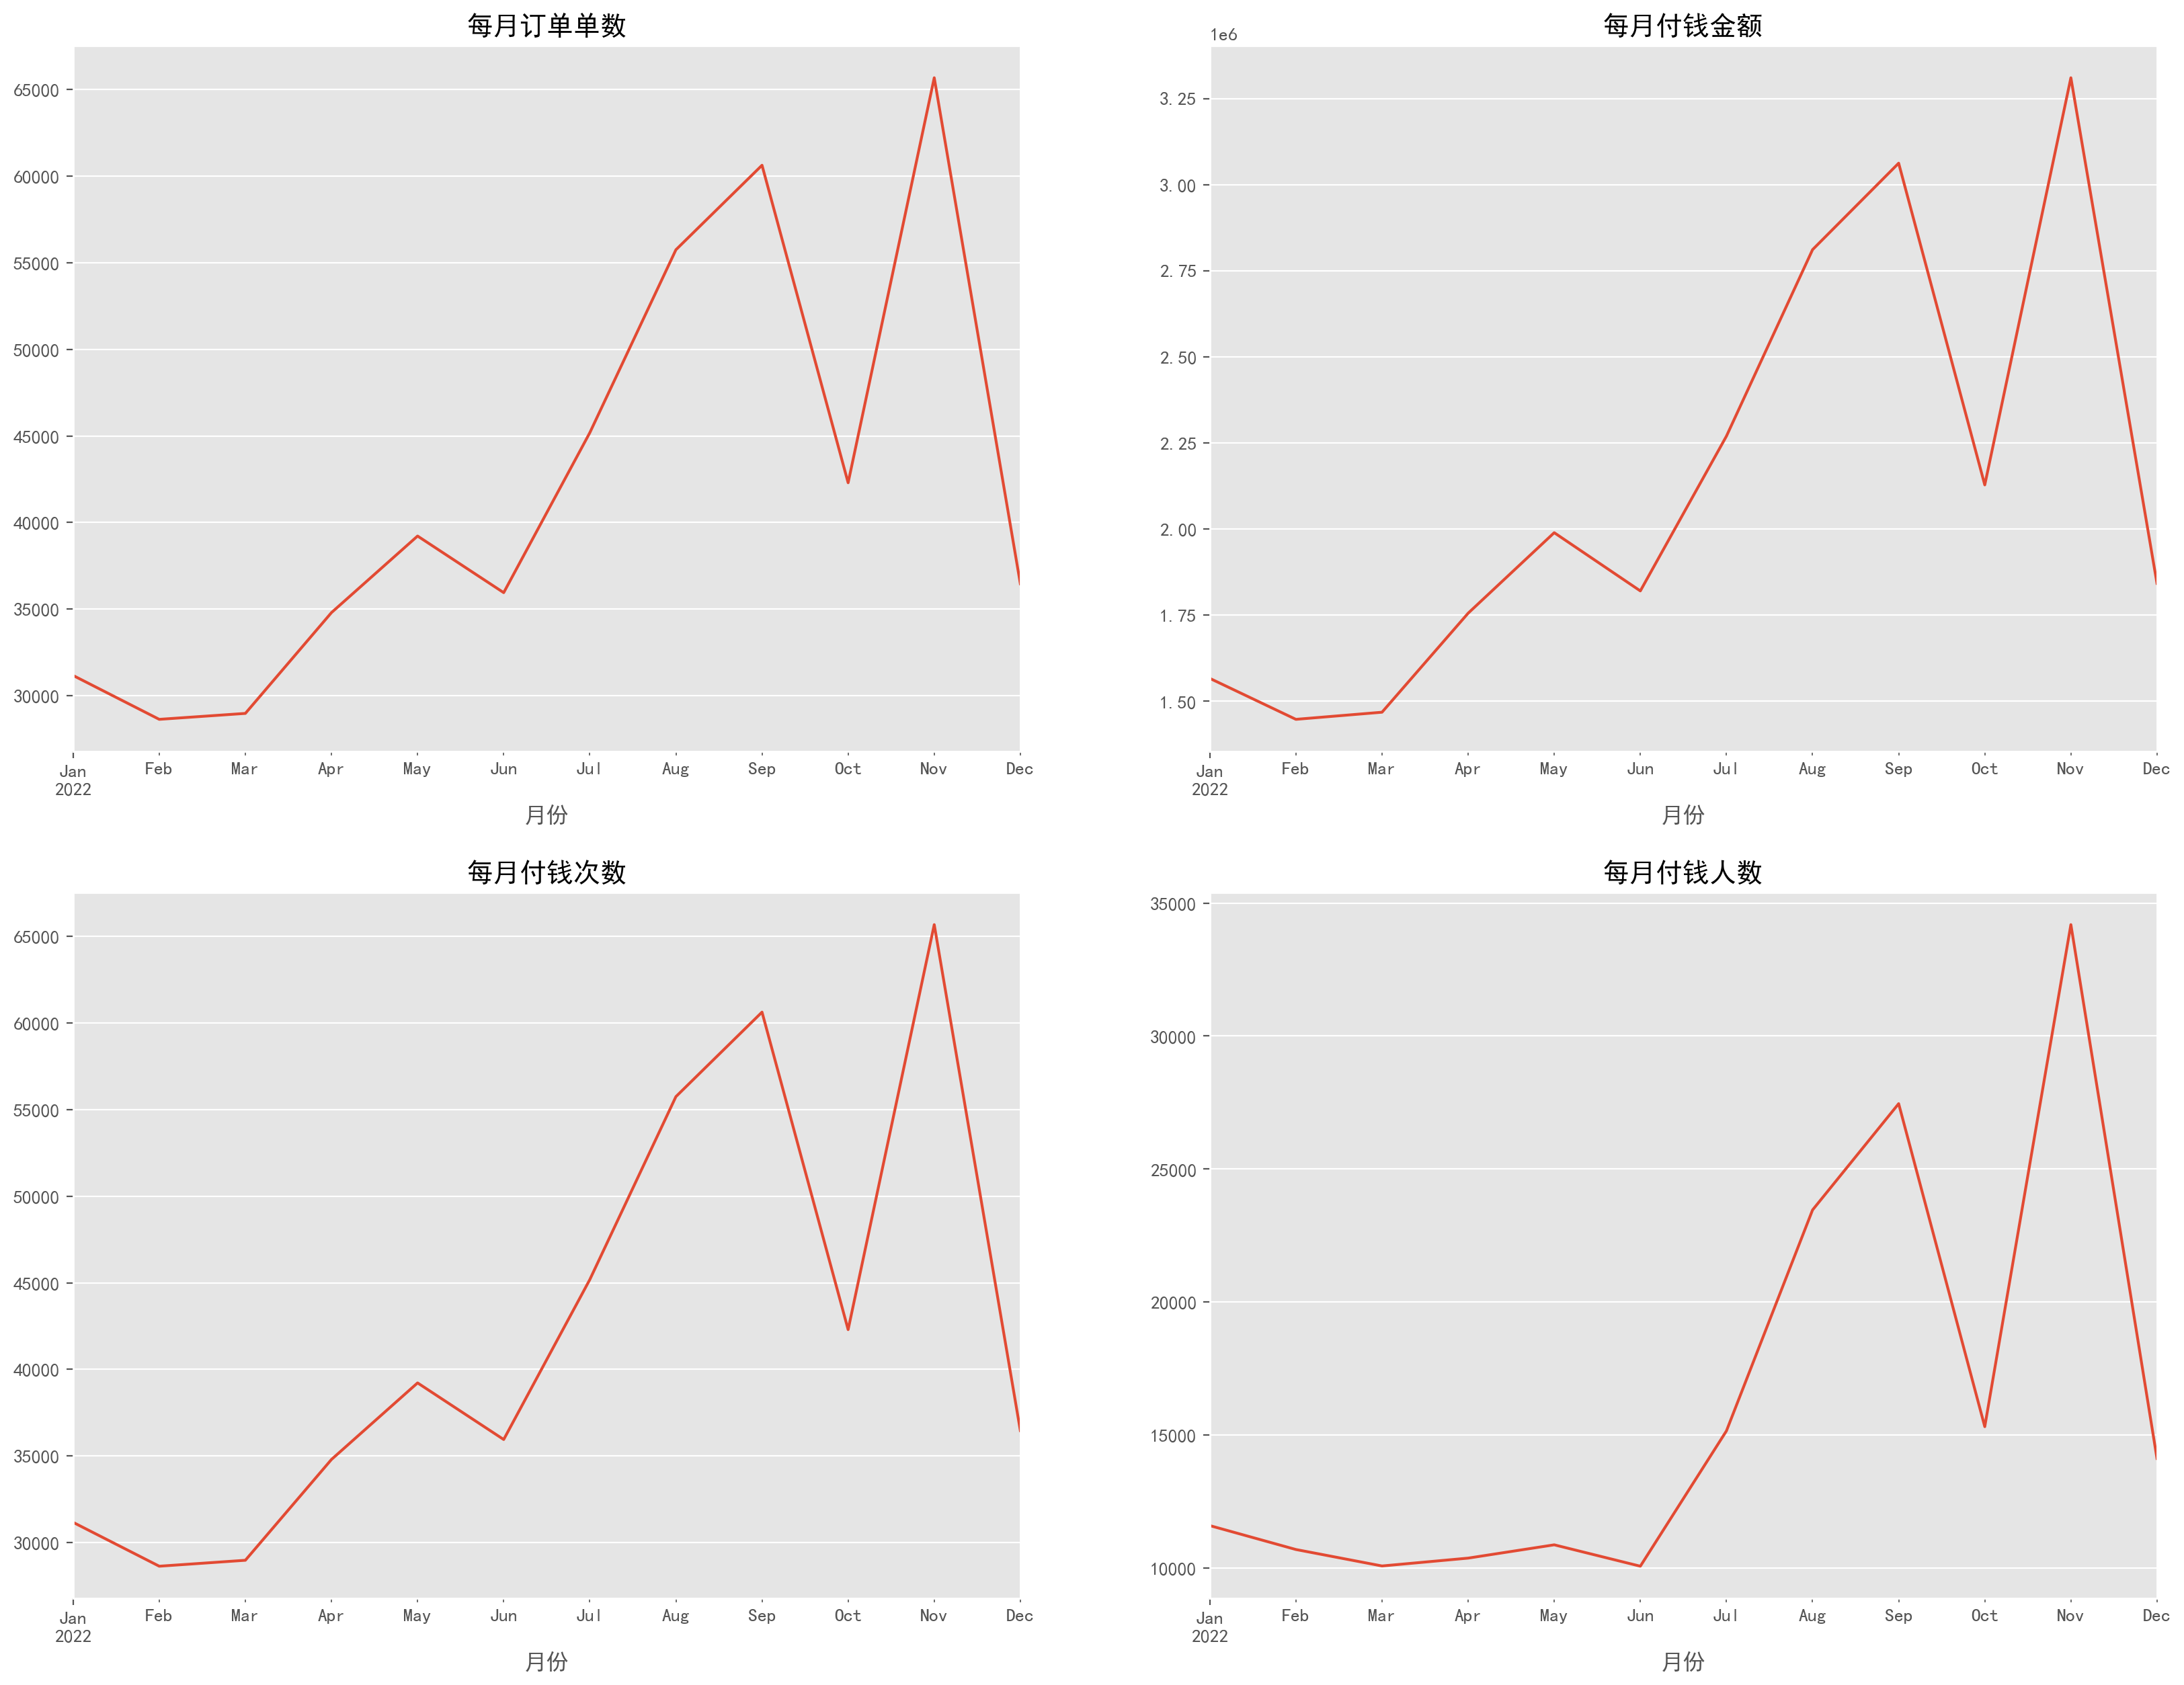

In [27]:
#用户整体消费分析
#每月订单数、金额总和、付钱次数、付钱人数
plt.figure(figsize=(20,15),dpi=200)
plt.subplot(221)
dff.groupby(by='月份')['用户id'].count().plot()
plt.title('每月订单单数')

plt.subplot(222)
dff.groupby(by='月份')['金额'].sum().plot()
plt.title('每月付钱金额')

plt.subplot(223)
dff.groupby(by='月份')['用户id'].count().plot()
plt.title('每月付钱次数')

plt.subplot(224)
dff.groupby(by='月份')['用户id'].apply(lambda x:len(x.drop_duplicates())).plot() #做去重
plt.title('每月付钱人数')

In [28]:
#分析结果
#第一季度表现低迷，年中开始迅速攀升
#主要集中于八九月和十一月
#关注下半年的措施

In [29]:
#用户个体消费分析
dff_grouped = dff.groupby(by='用户id').sum()
print(dff_grouped.describe())
print('用户数量：',len(dff_grouped))  

                  金额
count  136539.000000
mean      186.570365
std       622.051355
min         1.000000
25%        35.000000
50%        68.000000
75%       100.000000
max     17351.000000
用户数量： 136539


In [30]:
# 进行用户分组，取出付钱金额，进行求和，排序，重置索引
dff_cumsum = dff.groupby('用户id')['金额'].sum().sort_values().reset_index()
dff_cumsum

,用户id,金额
0,211002644,1
1,210064749,1
2,210992380,1
3,210459451,1
4,209278571,1
...,...,...
136534,209955550,15050
136535,207104114,15137
136536,205941771,15572
136537,209962569,15850


In [31]:
# 每个用户消费金额累加 cumsum函数
dff_cumsum['金额累加'] = dff_cumsum['金额'].cumsum()
dff_cumsum.tail()

,用户id,金额,金额累加
136534,209955550,15050,25410221
136535,207104114,15137,25425358
136536,205941771,15572,25440930
136537,209962569,15850,25456780
136538,208631115,17351,25474131


In [32]:
amount_total = dff_cumsum['金额累加'].max()  # 付钱金额总值
dff_cumsum['prop'] = dff_cumsum.apply(lambda x:x['金额累加']/amount_total,axis=1) #前xx名用户的总贡献率
dff_cumsum.tail()

,用户id,金额,金额累加,prop
136534,209955550,15050,25410221,0.997491
136535,207104114,15137,25425358,0.998085
136536,205941771,15572,25440930,0.998697
136537,209962569,15850,25456780,0.999319
136538,208631115,17351,25474131,1.000000


<AxesSubplot:>

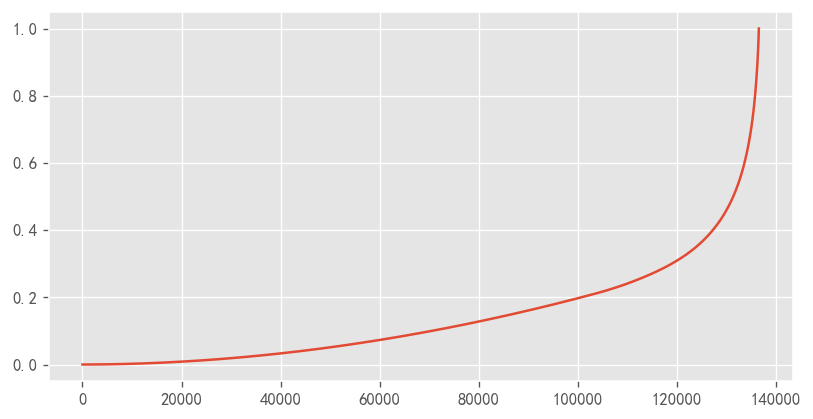

In [33]:
plt.figure(figsize=(8,4),dpi=120)
dff_cumsum['prop'].plot()

<AxesSubplot:>

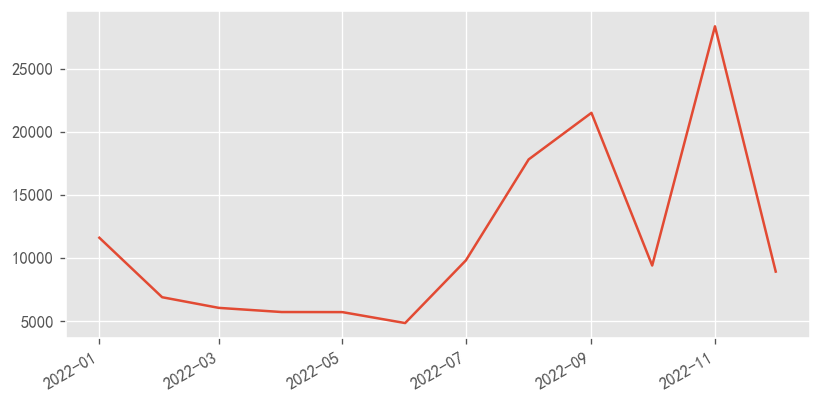

In [34]:
# 用户分组，取最小值 即为首购时间
plt.figure(figsize=(8,4),dpi=120)
dff.groupby(by='用户id')['月份'].min().value_counts().plot()

<AxesSubplot:>

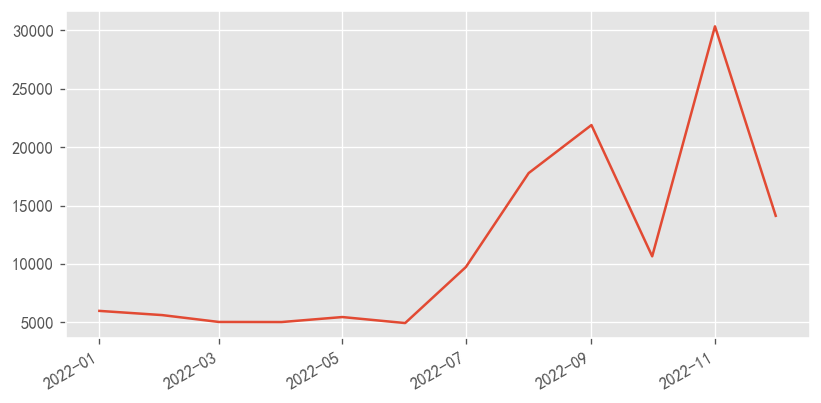

In [35]:
plt.figure(figsize=(8,4),dpi=120)
dff.groupby(by='用户id')['月份'].max().value_counts().plot()

In [36]:
#与整体消费分析结论一样，个体的首次和末次付钱也都存在于八九月与十一月

In [38]:
dff['订单数']='1'
dff.head()

,公会id,用户id,金额,日期,月份,订单数
0,0,210187396,97,2022-02-06,2022-02-01,1
1,10246.0,210231900,9,2022-05-23,2022-05-01,1
2,0,209525764,93,2022-11-26,2022-11-01,1
3,0.0,210191118,82,2022-01-03,2022-01-01,1
4,0,210800144,73,2022-09-20,2022-09-01,1


In [39]:
# 透视表的使用(index：相当于groupby分组，values：取出的数据列，aggfunc：key值必须存在于values中 且必须跟随有效的聚合函数)
rfm = dff.pivot_table(index='用户id',
                    values=['日期','订单数','金额'],
                    aggfunc={
                        '日期':'max',  # 最后一次购买
                        '订单数':'count',  # 总订单数
                        '金额':'sum'   # 消费总金额
,                    })
rfm.head()

,日期,订单数,金额
用户id,,,
0,2022-08-07,2,150
1,2022-11-07,3,142
26,2022-11-24,1,73
30,2022-09-07,5,304
31,2022-12-26,63,3325


In [40]:
rfm.shape

(136539, 3)

In [41]:
rfm['日期']=pd.to_datetime(rfm['日期'],format='%Y-%m-%d')
today=pd.to_datetime('2022-12-31')
rfm['R'] =(today-rfm['日期']).dt.days   #取相差的天数
rfm.rename(columns={'订单数':'F','金额':'M'},inplace=True)
rfm.head()

,日期,F,M,R
用户id,,,,
0,2022-08-07,2,150,146
1,2022-11-07,3,142,54
26,2022-11-24,1,73,37
30,2022-09-07,5,304,115
31,2022-12-26,63,3325,5


In [42]:
# RFM计算方式 ：每一列数据减去数据所在列的平均值（有正有负），根据结果值与1作比较，如果>=1，设置为1，否则为0
def rfm_func(x):  #x代表每一列数据
    level = x.apply(lambda x:'1' if x>=1 else '0')
    label = level['R'] + level['F'] + level['M']  # 举例：1 0 0    1 1 1
    d = {
        '111':'重要价值客户',
        '011':'重要保持客户',
        '101':'重要发展客户',
        '001':'重要挽留客户',
        '110':'一般价值客户',
        '010':'一般保持客户',
        '100':'一般发展客户',
        '000':'一般挽留客户'
    }
    result = d[label]
    return result
rfm['label'] = rfm[['R','F','M']].apply(lambda x:x-x.mean()).apply(rfm_func,axis=1) # axis=1 向右逐步取列
rfm.head()

,日期,F,M,R,label
用户id,,,,,
0,2022-08-07,2,150,146,一般发展客户
1,2022-11-07,3,142,54,一般挽留客户
26,2022-11-24,1,73,37,一般挽留客户
30,2022-09-07,5,304,115,重要保持客户
31,2022-12-26,63,3325,5,重要保持客户


Text(0, 0.5, 'M')

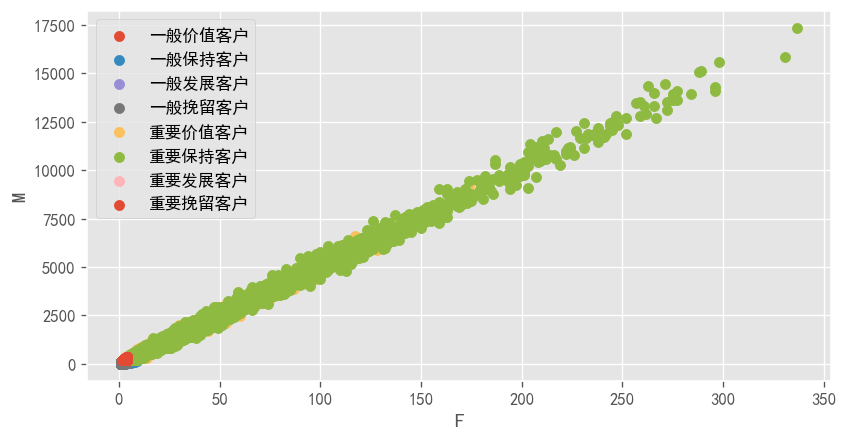

In [43]:
#用户分层可视化
plt.figure(figsize=(8,4),dpi=120)
for label,grouped in rfm.groupby(by='label'):
    x= grouped['F']
    y= grouped['M']
    plt.scatter(x,y,label=label)
plt.legend()
plt.xlabel('F')
plt.ylabel('M')